# Statements

Esta tabla contiene la información de las sentencias.  --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

full_table = get_data('statements')

# Table name, features and target.
TABLE_NAME = 'statements'
TABLE_FEATURES = ['statement__category', 'statement__parent', 'statement__statement_role', 'statement__first_child_category','statement__second_child_category','statement__third_child_category', 'statement__height', 'statement__depth', 'statement__has_or_else', 'statement__body_size', 'statement__expertise_level']
TABLE_TARGET = 'statement__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2024-05-28 12:53:35.814272 Data cache files found ...
2024-05-28 12:53:36.520924 Data cache files successfully loaded!!
Features shape: (1074760, 11)
Target shape: (1074760,)
As we can see the downloaded data contains a total of 1074760 instances. For each instance we have 11 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074760 entries, 0 to 1074759
Data columns (total 11 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   statement__category               1074760 non-null  object 
 1   statement__parent                 1074760 non-null  object 
 2   statement__statement_role         1074760 non-null  object 
 3   statement__first_child_category   931613 non-null   object 
 4   statement__second_child_category  574192 non-null   object 
 5   statement__third_child_category   11194 non-null    object 
 6   statement__height                 1074760 non-null  int64  
 7   statement__depth                  1074760 non-null  int64  
 8   statement__has_or_else            241044 non-null   object 
 9   statement__body_size              255237 non-null   float64
 10  statement__expertise_level        1074760 non-null  object 
dtypes: float64(1), int64(2), object(8)
me

Cómo podemos ver la tabla está compuesta por 3 variables numéricas y 8 de tipo objeto.

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 42.57% instances for BEGINNER class and 57.43% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [95.45%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

statement__category                       0
statement__parent                         0
statement__statement_role                 0
statement__first_child_category      143147
statement__second_child_category     500568
statement__third_child_category     1063566
statement__height                         0
statement__depth                          0
statement__has_or_else               833716
statement__body_size                 819523
statement__expertise_level                0
dtype: int64

### IMPORTANTE
Los nulos se deben a que esas variables solo son aplicables para ciertas categorias

In [6]:
print_empty_cols(X)

statement__category
-------------------
0 instancias no tienen un valor para la columna statement__category


statement__parent
-----------------
0 instancias no tienen un valor para la columna statement__parent


statement__statement_role
-------------------------
0 instancias no tienen un valor para la columna statement__statement_role


statement__first_child_category
-------------------------------
0 instancias no tienen un valor para la columna statement__first_child_category


statement__second_child_category
--------------------------------
0 instancias no tienen un valor para la columna statement__second_child_category


statement__third_child_category
-------------------------------
0 instancias no tienen un valor para la columna statement__third_child_category


statement__height
-----------------
0 instancias no tienen un valor para la columna statement__height


statement__depth
----------------
0 instancias no tienen un valor para la columna statement__depth


statement__h

### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
statement__category,1074760,21,AssignmentStmt,485714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__parent,1074760,11,FunctionDef,460984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__statement_role,1074760,20,MethodDefBody,260909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__first_child_category,931613,33,Variable,479672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__second_child_category,574192,35,Call,249004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__third_child_category,11194,29,Call,5299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__height,1074760.0,NaN,NaN,NaN,3.221554,1.958228,1.0,2.0,3.0,4.0,54.0
statement__depth,1074760.0,NaN,NaN,NaN,2.859124,2.102781,0.0,1.0,3.0,4.0,82.0
statement__has_or_else,241044,2,False,180804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__body_size,255237.0,NaN,NaN,NaN,1.895544,2.294126,1.0,1.0,1.0,2.0,276.0


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "statement__depth": [(0.0, 1.0), (1.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 0.0 max: 82.0
    "statement__height": [(0.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 1.0 max: 54.0
    "statement__body_size": [(1.0, 2.0), (2.0, inf)],  # min: 1.0 max: 276. Los Unkonwn son los None
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['statement__depth'], 10))
print(get_statistics(X_copy, ['statement__height'], 10))
print(get_statistics(X_copy, ['statement__body_size'], 10))
print(get_statistics(X_copy, ['statement__category'], 10))
print(get_statistics(X_copy, ['statement__first_child_category'], 10))
print(get_statistics(X_copy, ['statement__second_child_category'], 10))
print(get_statistics(X_copy, ['statement__third_child_category'], 10))
print(get_statistics(X_copy, ['statement__parent'], 10))
print(get_statistics(X_copy, ['statement__statement_role'], 10))
print(get_statistics(X_copy, ['statement__has_or_else'], 10))


# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['module__function_defs_pct', 'module__number_of_classes'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
statement__depth  count  percentage
       [1.0_3.0) 366666   34.116082
       [4.0_inf] 341824   31.804682
       [3.0_4.0) 238879   22.226264
       [0.0_1.0) 127391   11.852972

statement__height  count  percentage
        [3.0_4.0) 362373   33.716644
        [4.0_inf] 350290   32.592393
        [2.0_3.0) 215674   20.067178
        [0.0_2.0) 146423   13.623786

statement__body_size  count  percentage
             unknown 819523   76.251721
           [1.0_2.0) 158525   14.749805
           [2.0_inf]  96712    8.998474

statement__category  count  percentage
     AssignmentStmt 485714   45.192787
                 If 172162   16.018646
             Return 116172   10.809111
         ImportFrom  68903    6.411013
                For  44048    4.098403
             Assert  36653    3.410343
             Import  36263    3.374056
              Raise  23623    2.197979
AugmentedAssignment  20160    1.875768
                Try  15756    1.466002

statement__first_ch

In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (1074760, 156)
Target shape: (1074760,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

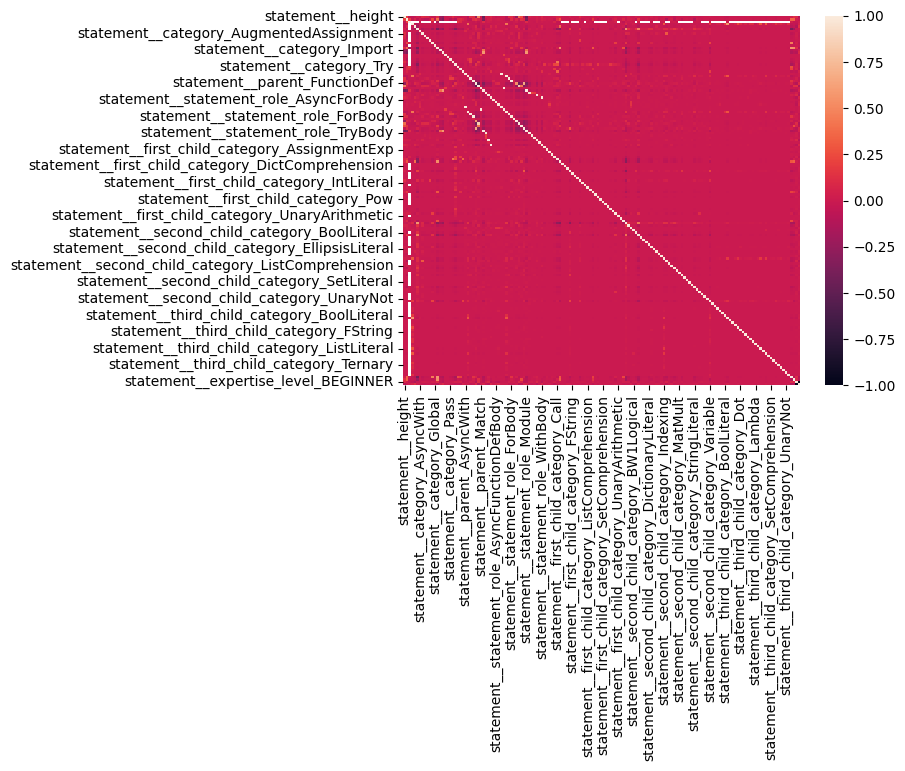

In [10]:
sns.heatmap(X.corr(), annot=False)

Se aprecian muchas relaciones pero habrá que mirar como mejorar este diagrama para que sea legible

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 10 variable (1 booleana, 3 numericas, 6 categorica) se hara un analisis detallado

### Variable has_or_else (1/10)
Esta variable es de tipo booleano y representa si ciertas categorias de statements tienen la clausula else. El primer paso es hacer un análisis visual de como se distribuyen los valores de la variable.

<Axes: xlabel='statement__has_or_else', ylabel='Count'>

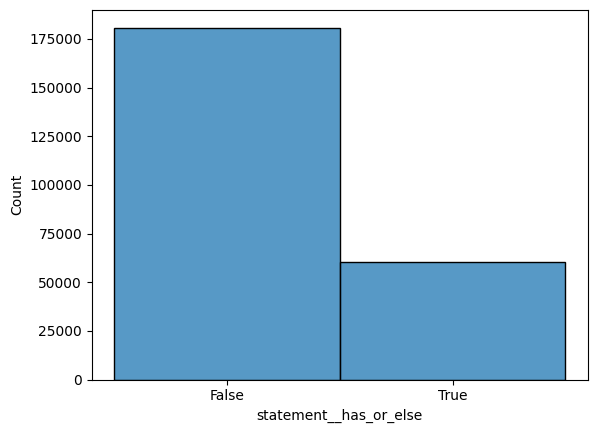

In [11]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(full_table['statement__has_or_else'], discrete=True)

In [12]:
num_true_values = len(full_table[full_table['statement__has_or_else'] == True])
num_false_values = len(full_table[full_table['statement__has_or_else'] == False])
std = full_table['statement__has_or_else'].std()
freq_true = len(full_table[full_table['statement__has_or_else'] == True]) / len(full_table['statement__has_or_else'])
freq_false = len(full_table[full_table['statement__has_or_else'] == False]) / len(full_table['statement__has_or_else'])
print(f'La variable has_or_else contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_or_else a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_or_else a False es {freq_false}.')

La variable has_or_else contiene 60240 valores verdaderos y 180804 valores falsos. Y, la desviación típica es de 0.43296328895983077
La frecuencia con la que programa puede tener la variable has_or_else a True es 0.05604972272879526.
La frecuencia con la que programa puede tener la variable has_or_else a False es 0.16822732517027056.


### IMPORTANTE
No suma el 100% debido a los valores nulos

In [13]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(full_table, 'statement__has_or_else', possible_values)

La variable statement__has_or_else contiene 3 valores distintos.
El umbral de outlier es de 0.06666666666666667%
La variable statement__has_or_else toma el valor de False en un 16.82% de los items.
La variable statement__has_or_else toma el valor de True en un 5.605% de los items.
La variable statement__has_or_else toma el valor de None en un 0.0% de los items. [OUTLIER]


In [14]:
full_table[full_table['statement__has_or_else'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__category,statement__parent,statement__statement_role,statement__first_child_category,statement__second_child_category,statement__third_child_category,statement__height,statement__depth,statement__has_or_else,statement__body_size,statement__expertise_level
count,60240,60240,60240,59290,349,0,60240.000000,60240.000000,60240,60240.000000,60240
unique,4,11,20,14,6,0,NaN,NaN,1,NaN,2
top,If,If,IfElseBody,Compare,Call,NaN,NaN,NaN,True,NaN,BEGINNER
freq,58865,28176,18448,32869,146,NaN,NaN,NaN,60240,NaN,34368
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.235309,5.794522,NaN,1.763695,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.986219,3.193044,NaN,1.692310,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,4.000000,NaN,1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,5.000000,NaN,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,7.000000,NaN,2.000000,NaN


### Variable height (2/10)
Esta variable representa la distancia del statement al root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 54. Con una media de 3.22.

<Axes: ylabel='statement__height'>

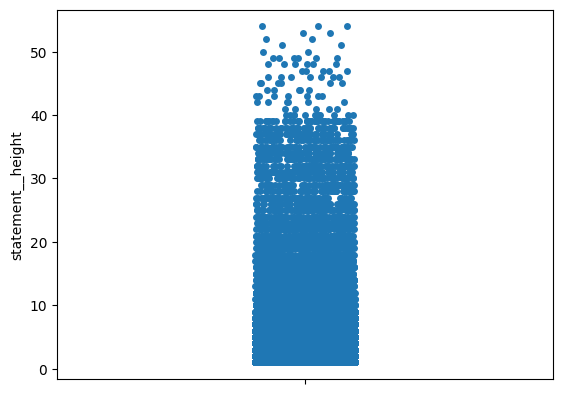

In [15]:
sns.stripplot(X['statement__height'])

In [16]:
print_outliers_for_df_column(X, 'statement__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8493972409446284
Rango valores atípicos extremos (Tukey): [-4.0,10.0]
Rango valores atípicos leves (Tukey): [-1.0,7.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.846534279273717,93.6758276169298]
-3.0IQR: 0 instancias tienen un valor para statement__height inferior a -4.0 (Q1-3*IQR) para statement__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para statement__height inferior a -1.0 (Q1-1.5*IQR) para statement__height. Representando un 0.0% del total de instancias.
+1.5IQR: 23743 instancias tienen un valor para statement__height superior a 7.0 (Q3+1.5*IQR) para statement__height. Representando un 2.209% del total de instancias.
+3.0IQR: 6253 instancias tienen un valor para statement__height superior a 10.0 (Q3-3*IQR) para statement__height. Representando un 0.5818% del total de instancias.
L: 146423 instancias tienen un valor para statement__height inferior a 1.84653427927

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 10.0 (Con un MC de 75 usamos Tuckey Extremo)

In [17]:
X[X['statement__height'] > 10].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__height,statement__depth,statement__body_size,statement__category_AnnotatedAssignment,statement__category_Assert,statement__category_AssignmentStmt,statement__category_AsyncWith,statement__category_AugmentedAssignment,statement__category_Break,statement__category_Continue,...,statement__third_child_category_StringLiteral,statement__third_child_category_Ternary,statement__third_child_category_TupleLiteral,statement__third_child_category_UnaryArithmetic,statement__third_child_category_UnaryNot,statement__third_child_category_Variable,statement__has_or_else_False,statement__has_or_else_True,statement__expertise_level_BEGINNER,statement__expertise_level_EXPERT
count,6253.000000,6253.000000,2312.000000,6253.0,6253.000000,6253.000000,6253.0,6253.000000,6253.000000,6253.000000,...,6253.0,6253.0,6253.0,6253.0,6253.0,6253.000000,6253.000000,6253.000000,6253.000000,6253.000000
mean,16.799295,4.749081,1.807526,0.0,0.003198,0.379658,0.0,0.093555,0.013753,0.004798,...,0.0,0.0,0.0,0.0,0.0,0.000640,0.126659,0.242444,0.572365,0.427635
std,7.771274,5.507038,1.390664,0.0,0.056469,0.485341,0.0,0.291232,0.116475,0.069105,...,0.0,0.0,0.0,0.0,0.0,0.025286,0.332617,0.428595,0.494775,0.494775
min,11.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,3.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
75%,19.000000,5.000000,2.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1.000000
max,54.000000,47.000000,11.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable depth (3/10)
Esta variable representa la distancia desde el statement hasta una hoja del ast. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 82. Con una media de 2.85.

<Axes: ylabel='statement__depth'>

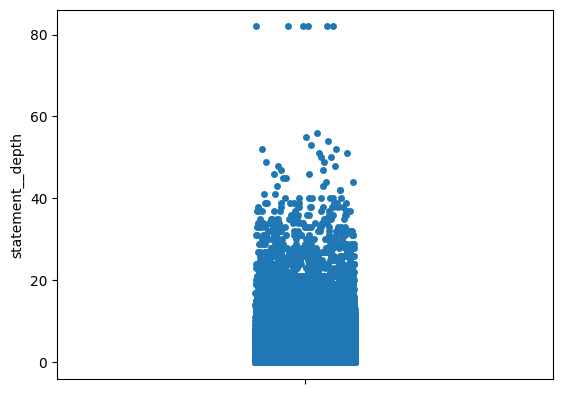

In [18]:
sns.stripplot(X['statement__depth'])

### IMPORTANTE
Los valores maximos estan muy alejados de los siguientes.

In [19]:
print_outliers_for_df_column(X, 'statement__depth')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9025333366733502
Rango valores atípicos extremos (Tukey): [-8.0,13.0]
Rango valores atípicos leves (Tukey): [-3.5,8.5]
Rango valores atípicos extremos (Fixed BoxPlot): [0.808867673435812,170.3694209998047]
-3.0IQR: 0 instancias tienen un valor para statement__depth inferior a -8.0 (Q1-3*IQR) para statement__depth. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para statement__depth inferior a -3.5 (Q1-1.5*IQR) para statement__depth. Representando un 0.0% del total de instancias.
+1.5IQR: 13583 instancias tienen un valor para statement__depth superior a 8.5 (Q3+1.5*IQR) para statement__depth. Representando un 1.264% del total de instancias.
+3.0IQR: 1722 instancias tienen un valor para statement__depth superior a 13.0 (Q3-3*IQR) para statement__depth. Representando un 0.1602% del total de instancias.
L: 127391 instancias tienen un valor para statement__depth inferior a 0.808867673435812 par

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 13.0 (Con un MC de 92 usamos Tuckey Extremo)

In [20]:
X[X['statement__depth'] > 13].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__height,statement__depth,statement__body_size,statement__category_AnnotatedAssignment,statement__category_Assert,statement__category_AssignmentStmt,statement__category_AsyncWith,statement__category_AugmentedAssignment,statement__category_Break,statement__category_Continue,...,statement__third_child_category_StringLiteral,statement__third_child_category_Ternary,statement__third_child_category_TupleLiteral,statement__third_child_category_UnaryArithmetic,statement__third_child_category_UnaryNot,statement__third_child_category_Variable,statement__has_or_else_False,statement__has_or_else_True,statement__expertise_level_BEGINNER,statement__expertise_level_EXPERT
count,1722.000000,1722.000000,1615.000000,1722.000000,1722.0,1722.000000,1722.000000,1722.0,1722.0,1722.0,...,1722.0,1722.0,1722.0,1722.0,1722.0,1722.0,1722.000000,1722.000000,1722.000000,1722.000000
mean,7.767712,20.005808,3.202477,0.000581,0.0,0.061556,0.000581,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.244483,0.692799,0.553426,0.446574
std,7.388257,8.014801,7.828505,0.024098,0.0,0.240418,0.024098,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.429905,0.461467,0.497282,0.497282
min,1.000000,14.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.000000,15.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,5.000000,17.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000
75%,10.000000,22.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000
max,44.000000,82.000000,276.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


### IMPORTANTE
Hay que revisar los 6 que tienen un valor mayor de 80 

### Variable body_size (4/10)
Esta variable representa el número de sentencias o expresiones que se definen dentro del cuerpo de ciertas categorías de sentencias. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 276. Con una media de 1.89.

<Axes: ylabel='statement__body_size'>

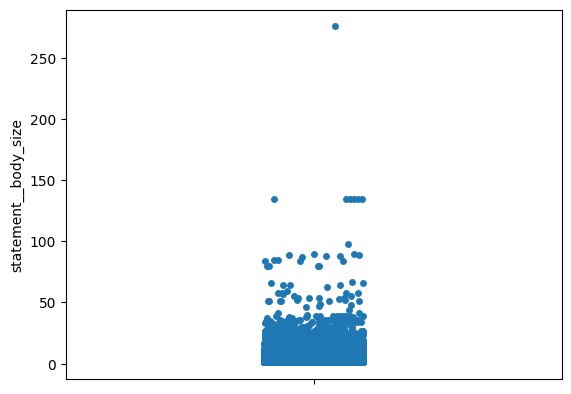

In [21]:
sns.stripplot(X['statement__body_size'])

### IMPORTANTE
El valor maximo esta muy alejado de los siguientes.

In [22]:
print_outliers_for_df_column(X,'statement__body_size')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8655190516356983
Rango valores atípicos extremos (Tukey): [-2.0,5.0]
Rango valores atípicos leves (Tukey): [-0.5,3.5]
Rango valores atípicos extremos (Fixed BoxPlot): [0.9274770033769737,49.82465562894081]
-3.0IQR: 0 instancias tienen un valor para statement__body_size inferior a -2.0 (Q1-3*IQR) para statement__body_size. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para statement__body_size inferior a -0.5 (Q1-1.5*IQR) para statement__body_size. Representando un 0.0% del total de instancias.
+1.5IQR: 25789 instancias tienen un valor para statement__body_size superior a 3.5 (Q3+1.5*IQR) para statement__body_size. Representando un 2.4% del total de instancias.
+3.0IQR: 9989 instancias tienen un valor para statement__body_size superior a 5.0 (Q3-3*IQR) para statement__body_size. Representando un 0.9294% del total de instancias.
L: 0 instancias tienen un valor para statement__body_size infe

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 50.0 (Con un MC de 86 usamos U)

In [23]:
X[X['statement__body_size'] > 49.82].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__height,statement__depth,statement__body_size,statement__category_AnnotatedAssignment,statement__category_Assert,statement__category_AssignmentStmt,statement__category_AsyncWith,statement__category_AugmentedAssignment,statement__category_Break,statement__category_Continue,...,statement__third_child_category_StringLiteral,statement__third_child_category_Ternary,statement__third_child_category_TupleLiteral,statement__third_child_category_UnaryArithmetic,statement__third_child_category_UnaryNot,statement__third_child_category_Variable,statement__has_or_else_False,statement__has_or_else_True,statement__expertise_level_BEGINNER,statement__expertise_level_EXPERT
count,52.000000,52.000000,52.00000,52.0,52.0,52.0,52.0,52.0,52.0,52.0,...,52.0,52.0,52.0,52.0,52.0,52.0,52.000000,52.000000,52.000000,52.000000
mean,1.403846,5.961538,79.57692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.923077,0.057692,0.519231,0.480769
std,0.664495,4.736018,37.92115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.269069,0.235435,0.504505,0.504505
min,1.000000,2.000000,51.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,54.75000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000
50%,1.000000,5.000000,66.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.000000
75%,2.000000,7.000000,88.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.000000,1.000000
max,4.000000,29.000000,276.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


### IMPORTANTE
Hay que revisar el que tiene 276

### Variable category (5/10)
Esta variable es de tipo categórica y representa el tipo de sentencia.

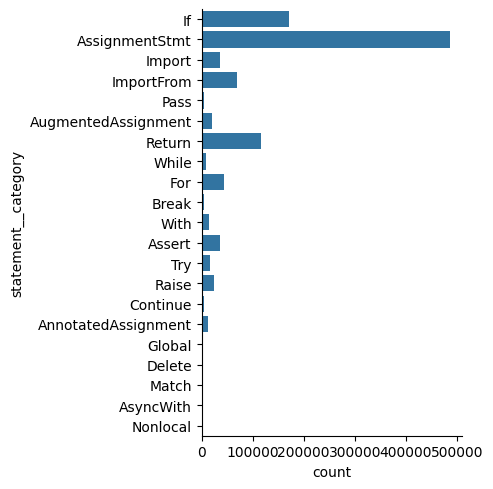

In [24]:
sns.catplot(full_table['statement__category'], kind="count")

In [25]:
print_frequency_anal_for_cat_var(full_table, 'statement__category')

La variable statement__category contiene 21 valores distintos.
El umbral de outlier es de 0.009523809523809525%
La variable statement__category toma el valor de AssignmentStmt en un 45.19% de los items.
La variable statement__category toma el valor de If en un 16.02% de los items.
La variable statement__category toma el valor de Return en un 10.81% de los items.
La variable statement__category toma el valor de ImportFrom en un 6.411% de los items.
La variable statement__category toma el valor de For en un 4.098% de los items.
La variable statement__category toma el valor de Assert en un 3.41% de los items.
La variable statement__category toma el valor de Import en un 3.374% de los items.
La variable statement__category toma el valor de Raise en un 2.198% de los items.
La variable statement__category toma el valor de AugmentedAssignment en un 1.876% de los items.
La variable statement__category toma el valor de Try en un 1.466% de los items.
La variable statement__category toma el valor

### Variable parent (6/10)
Esta variable es de tipo categórica y representa el tipo del padre de la sentencia.

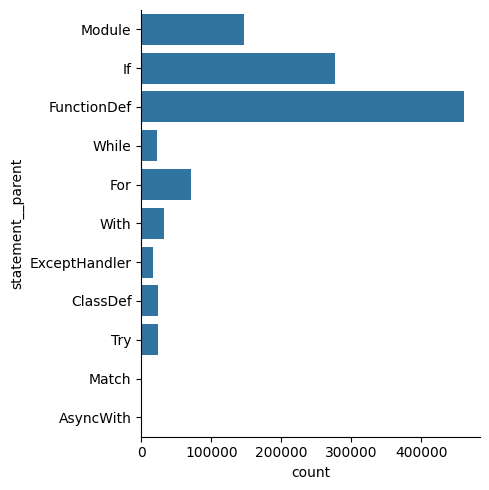

In [26]:
sns.catplot(full_table['statement__parent'], kind="count")

In [27]:
print_frequency_anal_for_cat_var(full_table, 'statement__parent')

La variable statement__parent contiene 11 valores distintos.
El umbral de outlier es de 0.018181818181818184%
La variable statement__parent toma el valor de FunctionDef en un 42.89% de los items.
La variable statement__parent toma el valor de If en un 25.72% de los items.
La variable statement__parent toma el valor de Module en un 13.62% de los items.
La variable statement__parent toma el valor de For en un 6.599% de los items.
La variable statement__parent toma el valor de With en un 3.03% de los items.
La variable statement__parent toma el valor de Try en un 2.263% de los items.
La variable statement__parent toma el valor de ClassDef en un 2.196% de los items.
La variable statement__parent toma el valor de While en un 2.061% de los items.
La variable statement__parent toma el valor de ExceptHandler en un 1.569% de los items.
La variable statement__parent toma el valor de AsyncWith en un 0.02214% de los items.
La variable statement__parent toma el valor de Match en un 0.01991% de los 

### Variable statement_role (7/10)
Esta variable es de tipo categórica y representa el rol que representa la sentencia en su padre.

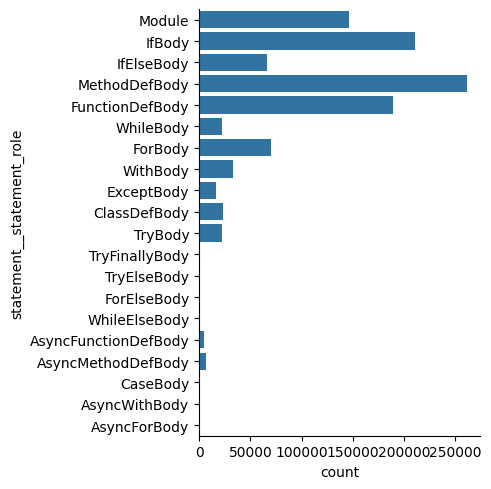

In [28]:
sns.catplot(full_table['statement__statement_role'], kind="count")

In [29]:
print_frequency_anal_for_cat_var(full_table, 'statement__statement_role')

La variable statement__statement_role contiene 20 valores distintos.
El umbral de outlier es de 0.01%
La variable statement__statement_role toma el valor de MethodDefBody en un 24.28% de los items.
La variable statement__statement_role toma el valor de IfBody en un 19.56% de los items.
La variable statement__statement_role toma el valor de FunctionDefBody en un 17.56% de los items.
La variable statement__statement_role toma el valor de Module en un 13.62% de los items.
La variable statement__statement_role toma el valor de ForBody en un 6.529% de los items.
La variable statement__statement_role toma el valor de IfElseBody en un 6.167% de los items.
La variable statement__statement_role toma el valor de WithBody en un 3.03% de los items.
La variable statement__statement_role toma el valor de ClassDefBody en un 2.196% de los items.
La variable statement__statement_role toma el valor de TryBody en un 2.079% de los items.
La variable statement__statement_role toma el valor de WhileBody en 

### Variable first_child_category (8/10)
Esta variable es de tipo categorica y representa la categoria del primer hijo de la sentencia.

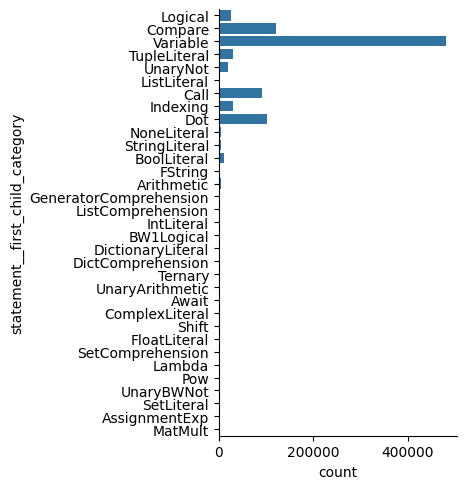

In [30]:
sns.catplot(full_table['statement__first_child_category'], kind="count")

In [31]:
print_frequency_anal_for_cat_var(full_table, 'statement__first_child_category')

La variable statement__first_child_category contiene 34 valores distintos.
El umbral de outlier es de 0.0058823529411764705%
La variable statement__first_child_category toma el valor de Variable en un 44.63% de los items.
La variable statement__first_child_category toma el valor de Compare en un 11.22% de los items.
La variable statement__first_child_category toma el valor de Dot en un 9.497% de los items.
La variable statement__first_child_category toma el valor de Call en un 8.5% de los items.
La variable statement__first_child_category toma el valor de TupleLiteral en un 2.851% de los items.
La variable statement__first_child_category toma el valor de Indexing en un 2.779% de los items.
La variable statement__first_child_category toma el valor de Logical en un 2.462% de los items.
La variable statement__first_child_category toma el valor de UnaryNot en un 1.789% de los items.
La variable statement__first_child_category toma el valor de BoolLiteral en un 0.9965% de los items.
La vari

### Variable second_child_category (9/10)
Esta variable es de tipo categorica y representa la categoria del segundo hijo de la sentencia.

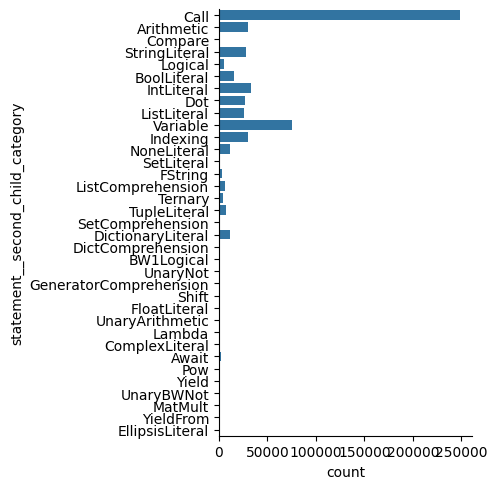

In [32]:
sns.catplot(full_table['statement__second_child_category'], kind="count")

In [33]:
print_frequency_anal_for_cat_var(full_table, 'statement__second_child_category')

La variable statement__second_child_category contiene 36 valores distintos.
El umbral de outlier es de 0.005555555555555556%
La variable statement__second_child_category toma el valor de Call en un 23.17% de los items.
La variable statement__second_child_category toma el valor de Variable en un 7.059% de los items.
La variable statement__second_child_category toma el valor de IntLiteral en un 3.038% de los items.
La variable statement__second_child_category toma el valor de Indexing en un 2.788% de los items.
La variable statement__second_child_category toma el valor de Arithmetic en un 2.756% de los items.
La variable statement__second_child_category toma el valor de StringLiteral en un 2.591% de los items.
La variable statement__second_child_category toma el valor de Dot en un 2.478% de los items.
La variable statement__second_child_category toma el valor de ListLiteral en un 2.44% de los items.
La variable statement__second_child_category toma el valor de BoolLiteral en un 1.444% de

### Variable third_child_category (10/10)
Esta variable es de tipo categorica y representa la categoria del tercer hijo de la sentencia.

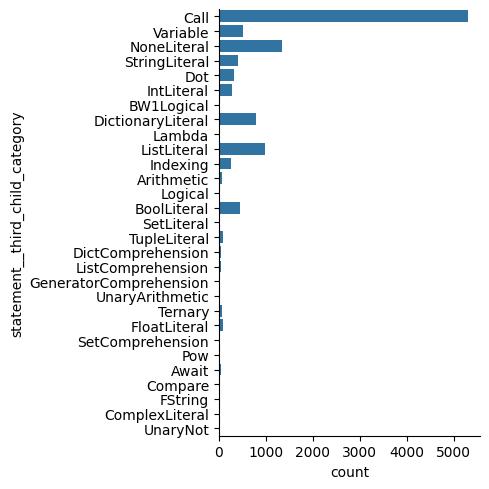

In [34]:
sns.catplot(full_table['statement__third_child_category'], kind="count")

In [35]:
print_frequency_anal_for_cat_var(full_table, 'statement__third_child_category')

La variable statement__third_child_category contiene 30 valores distintos.
El umbral de outlier es de 0.006666666666666667%
La variable statement__third_child_category toma el valor de Call en un 0.493% de los items.
La variable statement__third_child_category toma el valor de NoneLiteral en un 0.1244% de los items.
La variable statement__third_child_category toma el valor de ListLiteral en un 0.0909% de los items.
La variable statement__third_child_category toma el valor de DictionaryLiteral en un 0.07313% de los items.
La variable statement__third_child_category toma el valor de Variable en un 0.04717% de los items.
La variable statement__third_child_category toma el valor de BoolLiteral en un 0.04103% de los items.
La variable statement__third_child_category toma el valor de StringLiteral en un 0.03871% de los items.
La variable statement__third_child_category toma el valor de Dot en un 0.03033% de los items.
La variable statement__third_child_category toma el valor de IntLiteral en

## Multivariate

TODO: isolation forest algorithm

In [36]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values